# Pre-processing & Feature Engineering

## Import Necessary Packages & Data

In [46]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

In [2]:
#Get the relative local folder where the data is stored
base_fpath = os.getcwd() #the file path to the working directory of the code
d_path = base_fpath.replace('notebooks', 'data') #raw data file path

s_data = pd.read_csv(d_path + '/gas_data_cleaned.csv') #sensor data

## Prepare the Data

Based on the findings from the last notebook we will want to create multiple dataframes, each capable of being ran in the future models we create. Each data frame will have their own pros and cons, which will be discussed during their creation. However, lets first start off by spliting the data into 3 sets: train, test, and future.
The training dataset will be used to create a scaling method and to build our models.
The test dataset will be used to verify our model and provide metrics on goodness of fit.
The last dataset, arbitrarily named future, will consist of the data that was captured as part of later batches (i.e. at later dates). The future dataset will be used to evaluate the model's goodness of fit over time and help us determine if any of the sensors lose accuracy in measurement over time (often called drift).

### Split the Data

The first thing we need to decide is which batches we should use for training and testing, and which ones should be used for all other data. I'm sure there is a good matematical guideline for determining how many data points are needed, but lets first look at how many data points are in each batch.

In [3]:
batch_data = pd.DataFrame(s_data['BatchNumber'].value_counts(sort=False).sort_index())
batch_data.rename(columns= {'BatchNumber': '# of Runs'}, inplace=True)
batch_data['% of Data'] = batch_data['# of Runs'] / len(s_data) * 100
batch_data

,# of Runs,% of Data
1,445,3.199137
2,1244,8.943206
3,1586,11.401869
4,161,1.157441
5,197,1.416247
6,2300,16.534867
7,3613,25.974119
8,294,2.113587
9,470,3.378864
10,3600,25.880661


The first five batches represent approximately 25% of the data or 3633 runs. If we were keeping the same number of dimensions that we currently have it would lead to a sparsely populated dimensional space. However, since we will be reducing the feature space, I think this is an acceptable number of data points to build and validate a model.

In [4]:
ind_vars = s_data.drop(columns=['ChemicalCode', 'Concentration', 'BatchNumber']).columns #column names of the independent variables
tt_data = s_data[s_data['BatchNumber'] <= 5] #train test dataset
X_tt = tt_data[ind_vars] #train test independent variable dataset
y_tt_code = tt_data['ChemicalCode'] #1st dependent variable
y_tt_con = tt_data['Concentration'] #2nd dependent variable

X_train, X_test, y_code_train, y_code_test = train_test_split(X_tt, y_tt_code, test_size=.3, random_state=1991) #split the data 1st time
X_train2, X_test2, y_con_train, y_con_test = train_test_split(X_tt, y_tt_con, test_size=.3, random_state=1991) #split the data for the second dependent variable, should be the same
if (X_train['DR_1'] != X_train2['DR_1']).sum() == 0:
    print('Independent datasets from concentration split and chemical code split match so can keep just one X_train and X_test')
else:
    print('Splits do not match so need to keep X_train, X_train2, X_test, and X_test2')


f_data = s_data[s_data['BatchNumber'] > 5] #future dataset
X_f = f_data[ind_vars] #train test independent variable dataset
y_f_code = f_data['ChemicalCode'] #1st dependent variable
y_f_con = f_data['Concentration'] #2nd dependent variable

Independent datasets from concentration split and chemical code split match so can keep just one X_train and X_test


### Scale the Data

Lets scale the data by stanardizing it such that the mean is 0 and the standard deviation is 1. I believe good practice dictates that we fit on the training data and transform the others based on that fitted scale.

In [5]:
ss = StandardScaler().fit(X_train)
X_train_s = pd.DataFrame(ss.transform(X_train), columns=ind_vars)
X_test_s = pd.DataFrame(ss.transform(X_test), columns=ind_vars)
X_f_s = pd.DataFrame(ss.transform(X_f), columns=ind_vars)

## Feature Engingeering & Selection

### Highly Correlated Feature Selection

As a reminder from the last notebook in which we did exploratory data analysis, a lot of our features are highly correlated. One way we can reduce the nubmer of features while keeping most of the variance is removing one of the features in a high correlation pairing. The method we will deploy here is to keep the feature that is highly correlated to the most other variables and remove the features it is correlated with then repeat with the remaining fatures until all remaining features are no longer highly correlated.

In [25]:
def remove_high_corr_vars(mat, corr_thresh):
    ivars = mat.columns.tolist()
    corr_mat = mat.corr()
    high_corr = [] #list for combinations that have a high correlation
    
    for c in range(len(ivars) - 1):
        for i in range(c+1, len(ivars) - 1):
            if abs(corr_mat.iloc[i,c]) > corr_thresh:
                high_corr.append((ivars[c], ivars[i]))
    
    if len(high_corr) == 0:
        return None, []
    
    else:
        ivars_corr = [i[0] for i in high_corr] + [i[0] for i in high_corr] #add each variable in a pair to a single list
        corr_count = pd.DataFrame([i[0] for i in high_corr] + [i[0] for i in high_corr]).value_counts() #value count of each variable
        max_var = corr_count.index[0][0] #variable to keep

        remove_list = []
        for p in high_corr:
            if max_var in p:
                i_opp = (p.index(max_var) + 1) % 2 #index of the variable that doesn't have the most connections in the current pairing
                remove_list.append(p[i_opp])
            
        return max_var, remove_list

In [27]:
used_vars = []
removed_vars = []
corr_thresh = 0.8

more_high_corr = True #boolean for if there are more high correlation variables

while more_high_corr:
    mat = X_train_s.drop(columns = removed_vars)
    max_var, to_remove = remove_high_corr_vars(mat, corr_thresh)
    
    if max_var == None:
        more_high_corr = False
        
    else:
        used_vars.append(max_var)
        removed_vars = removed_vars + to_remove
        
print('Number of remaining features: ' + str(len(mat.columns)))
print(mat.columns)

Number of remaining features: 18
Index(['DR_1', '|DR|_1', '|DR|_3', 'EMAi0.01_3', 'EMAi0.1_3', 'EMAd0.1_3',
       'EMAd0.01_4', 'DR_5', '|DR|_5', 'EMAi0.01_5', 'EMAd0.01_5',
       'EMAd0.01_6', 'EMAd0.1_6', 'EMAi0.001_7', 'EMAd0.1_8', 'EMAi0.01_13',
       'EMAd0.01_15', 'EMAd0.1_16'],
      dtype='object')


Using this elimination method we now have only 18 features all of which should not be highly correlated with each other. An added benefit is that only 10 of the sensors are being used instead of all 16. Lets quickly view what the remaining features look like in a pair plot and then apply the removal list to all three of our independent variable datasets before saving.

<Figure size 2520x1800 with 0 Axes>

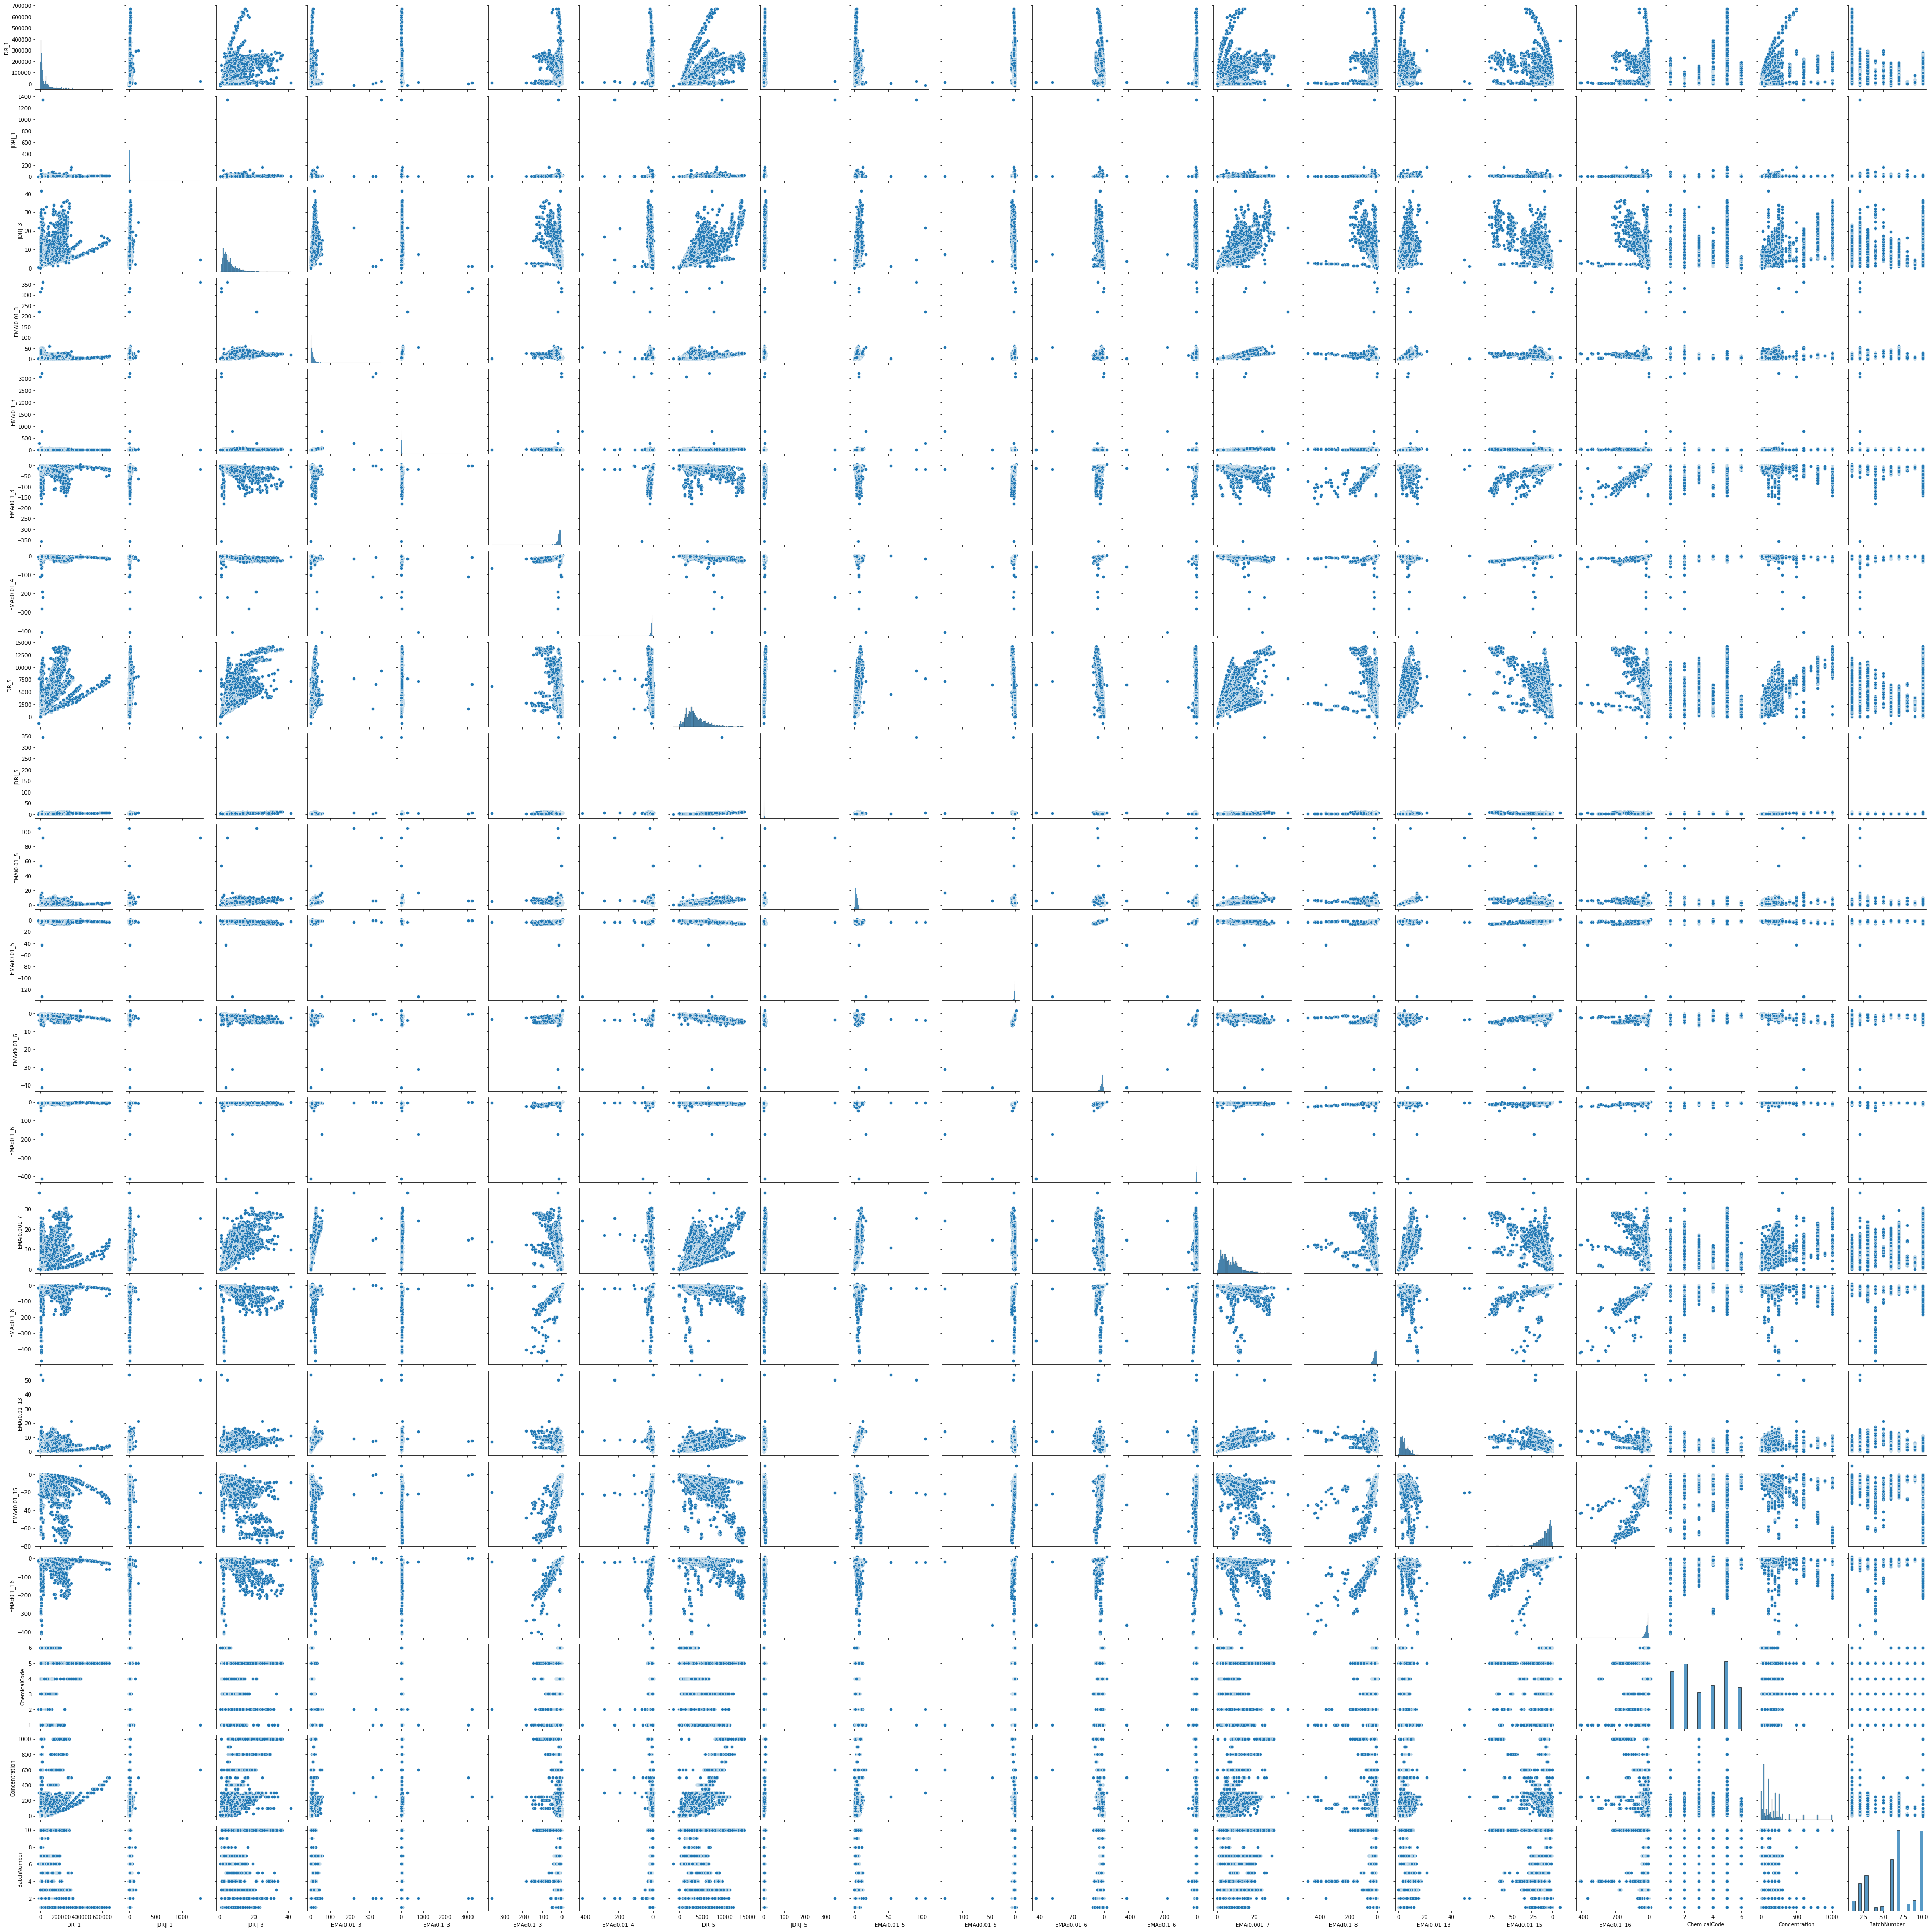

In [30]:
fig = plt.figure(figsize=(35,25))
sns.pairplot(s_data.drop(columns=removed_vars))
plt.show()

In [41]:
X_train_s.drop(columns=removed_vars).to_csv(d_path + '/CorrelationMethod/train.csv', index=False)
X_test_s.drop(columns=removed_vars).to_csv(d_path + '/CorrelationMethod/test.csv', index=False)
X_f_s.drop(columns=removed_vars).to_csv(d_path + '/CorrelationMethod/future.csv', index=False)

One final note after plotting the remaining features is that we can see 4 to 6 distint outlier values. These outliers could have impacted our correlation results

### PCA Feature Reduction

lets now create a dataset, but using the PCA method for feature reduction. From our data exploration we determined that 11 components were significant, but we should now redo that analysis using only the training data since that is all that would be given.

In [40]:
pca = PCA().fit(X_train_s)
pca_var = pd.DataFrame(pca.explained_variance_ratio_)
pca_var[pca_var[0] >= 0.01]

,0
0,0.438922
1,0.224914
2,0.074591
3,0.056450
4,0.049282
5,0.034273
6,0.025127
7,0.017558
8,0.015060
9,0.012348


We can see now using only the training data that we have identified 10 significant components. lets fit our datasets to 10 components and save the data.

In [43]:
pca = PCA(n_components=10).fit(X_train_s)
columns = ['comp'+str(i) for i in range(10)]
pd.DataFrame(pca.transform(X_train_s), columns=columns).to_csv(d_path + '/PCAMethod/train.csv', index=False)
pd.DataFrame(pca.transform(X_test_s), columns=columns).to_csv(d_path + '/PCAMethod/test.csv', index=False)
pd.DataFrame(pca.transform(X_f_s), columns=columns).to_csv(d_path + '/PCAMethod/future.csv', index=False)

### LASSO Regression Feature Reduction

Just to try one more method of reducing features, lets try to use the LASSO regression method. Since it is a regression method we will have to use our chemical concentration value as the target, so this set of features may not work as well on predicting which chemical is being processed.

In [52]:
#fit the regression model
lasso = Lasso().fit(X_train_s, y_con_train)

#use the non-zero coefficient components
lasso_feats = X_train_s.columns[abs(lasso.coef_) > 0].tolist()
print('The number of features remaining are: ' + str(len(lasso_feats)))
print(lasso_feats)

The number of features remaining are: 20
['EMAi0.1_1', 'EMAi0.1_3', 'EMAd0.1_3', 'DR_5', 'EMAd0.01_5', 'EMAd0.001_6', 'EMAd0.1_6', '|DR|_7', 'EMAi0.01_7', 'EMAd0.001_7', 'EMAd0.1_8', '|DR|_10', 'EMAd0.1_10', 'DR_11', 'EMAi0.001_12', 'EMAi0.01_13', 'EMAi0.001_14', 'EMAd0.001_14', 'EMAd0.1_15', 'EMAi0.01_16']


looks like the default settings for the lasso method resulted in 20 features being important. lets now save the independent variable datasets using these features.

In [53]:
X_train_s[lasso_feats].to_csv(d_path + '/LASSOMethod/train.csv', index=False)
X_test_s[lasso_feats].to_csv(d_path + '/LASSOMethod/test.csv', index=False)
X_f_s[lasso_feats].to_csv(d_path + '/LASSOMethod/future.csv', index=False)